<a href="https://colab.research.google.com/github/sr-bn98/skills-copilot-codespaces-vscode/blob/main/proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

I use NumPy, Pandas, OpenCV, and scikit-learn for data manipulation, preprocessing, and splitting. For visualizing data and results I use Matplotlib. And finally use Pytorch to build and train deep learning models with various layers and callbacks.

In [40]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 10.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=ed25ddb7bea1e4a9ffed40487ef5c61e010a8143881108257ed0c4c229fbfb5e
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=278d8870896d3f8c0c1195d6d76dbe7a0ee42c745a0318a43d9c42d2f695992c
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels


In [43]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 11.8 MB/s eta 0:00:00


In [2]:

import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from rich.console import Console
from rich.table import Table

import torch
import torchvision.transforms as transforms
from PIL import Image
from torchmetrics import Dice
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader ,  random_split
import torchvision.transforms as transforms

I also set a seed for reproducibility and consistent results across runs:

In [3]:



seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


# **1. Dataset Familiarization**

The dataset is located at https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/code Each patient has a folder containing images and masks.

In [4]:
#from google.colab import files
#files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation



cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 99% 707M/714M [00:06<00:00, 193MB/s]
100% 714M/714M [00:06<00:00, 113MB/s]


In [5]:
!unzip lgg-mri-segmentation.zip  > /dev/null 2>&1

!rm -rf lgg-mri-segmentation.zip

In [6]:
dataset_path = '/content/kaggle_3m'

patients = os.listdir(dataset_path)
print(f"Total patients in the dataset: {len(patients)}")

Total patients in the dataset: 112


I explore the files in a sample patient's folder to understand the dataset structure, where each patient's image is in .tif format, and the corresponding mask file ends with _mask in its name.

In [7]:
example_patient = random.choice(patients)
example_patient_path = os.path.join(dataset_path, example_patient)
print(f"Files in {example_patient}:")
print(os.listdir(example_patient_path))

Files in TCGA_FG_6688_20020215:
['TCGA_FG_6688_20020215_9_mask.tif', 'TCGA_FG_6688_20020215_35.tif', 'TCGA_FG_6688_20020215_5.tif', 'TCGA_FG_6688_20020215_18_mask.tif', 'TCGA_FG_6688_20020215_13.tif', 'TCGA_FG_6688_20020215_8_mask.tif', 'TCGA_FG_6688_20020215_36_mask.tif', 'TCGA_FG_6688_20020215_16_mask.tif', 'TCGA_FG_6688_20020215_17_mask.tif', 'TCGA_FG_6688_20020215_24_mask.tif', 'TCGA_FG_6688_20020215_30.tif', 'TCGA_FG_6688_20020215_21.tif', 'TCGA_FG_6688_20020215_27_mask.tif', 'TCGA_FG_6688_20020215_9.tif', 'TCGA_FG_6688_20020215_20.tif', 'TCGA_FG_6688_20020215_1_mask.tif', 'TCGA_FG_6688_20020215_30_mask.tif', 'TCGA_FG_6688_20020215_16.tif', 'TCGA_FG_6688_20020215_10_mask.tif', 'TCGA_FG_6688_20020215_33_mask.tif', 'TCGA_FG_6688_20020215_18.tif', 'TCGA_FG_6688_20020215_20_mask.tif', 'TCGA_FG_6688_20020215_2.tif', 'TCGA_FG_6688_20020215_4.tif', 'TCGA_FG_6688_20020215_29_mask.tif', 'TCGA_FG_6688_20020215_28.tif', 'TCGA_FG_6688_20020215_11_mask.tif', 'TCGA_FG_6688_20020215_21_mask.tif'

Then, I'll get image and mask paths for the example patient:

In [8]:
def get_image_mask_paths(patient_path):
    image_paths = glob(os.path.join(patient_path, '*.tif'))
    mask_paths = [path for path in image_paths if 'mask' in os.path.basename(path)]
    image_paths = [path for path in image_paths if 'mask' not in os.path.basename(path)]
    return image_paths, mask_paths

image_paths, mask_paths = get_image_mask_paths(example_patient_path)
print(f"Number of images: {len(image_paths)}, Number of masks: {len(mask_paths)}")

Number of images: 36, Number of masks: 36


# Display 10 Images and Their Corresponding Masks
I'll randomly selects 10 images and their corresponding mask paths
Each image is read and converted to RGB format, while masks are read in color format.

Contours from the mask are extracted using cv2.findContours and overlaid on the image in red using cv2.drawContours.

The visualization is arranged in three columns: the image, the mask, and the image with the mask overlaid.

(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)


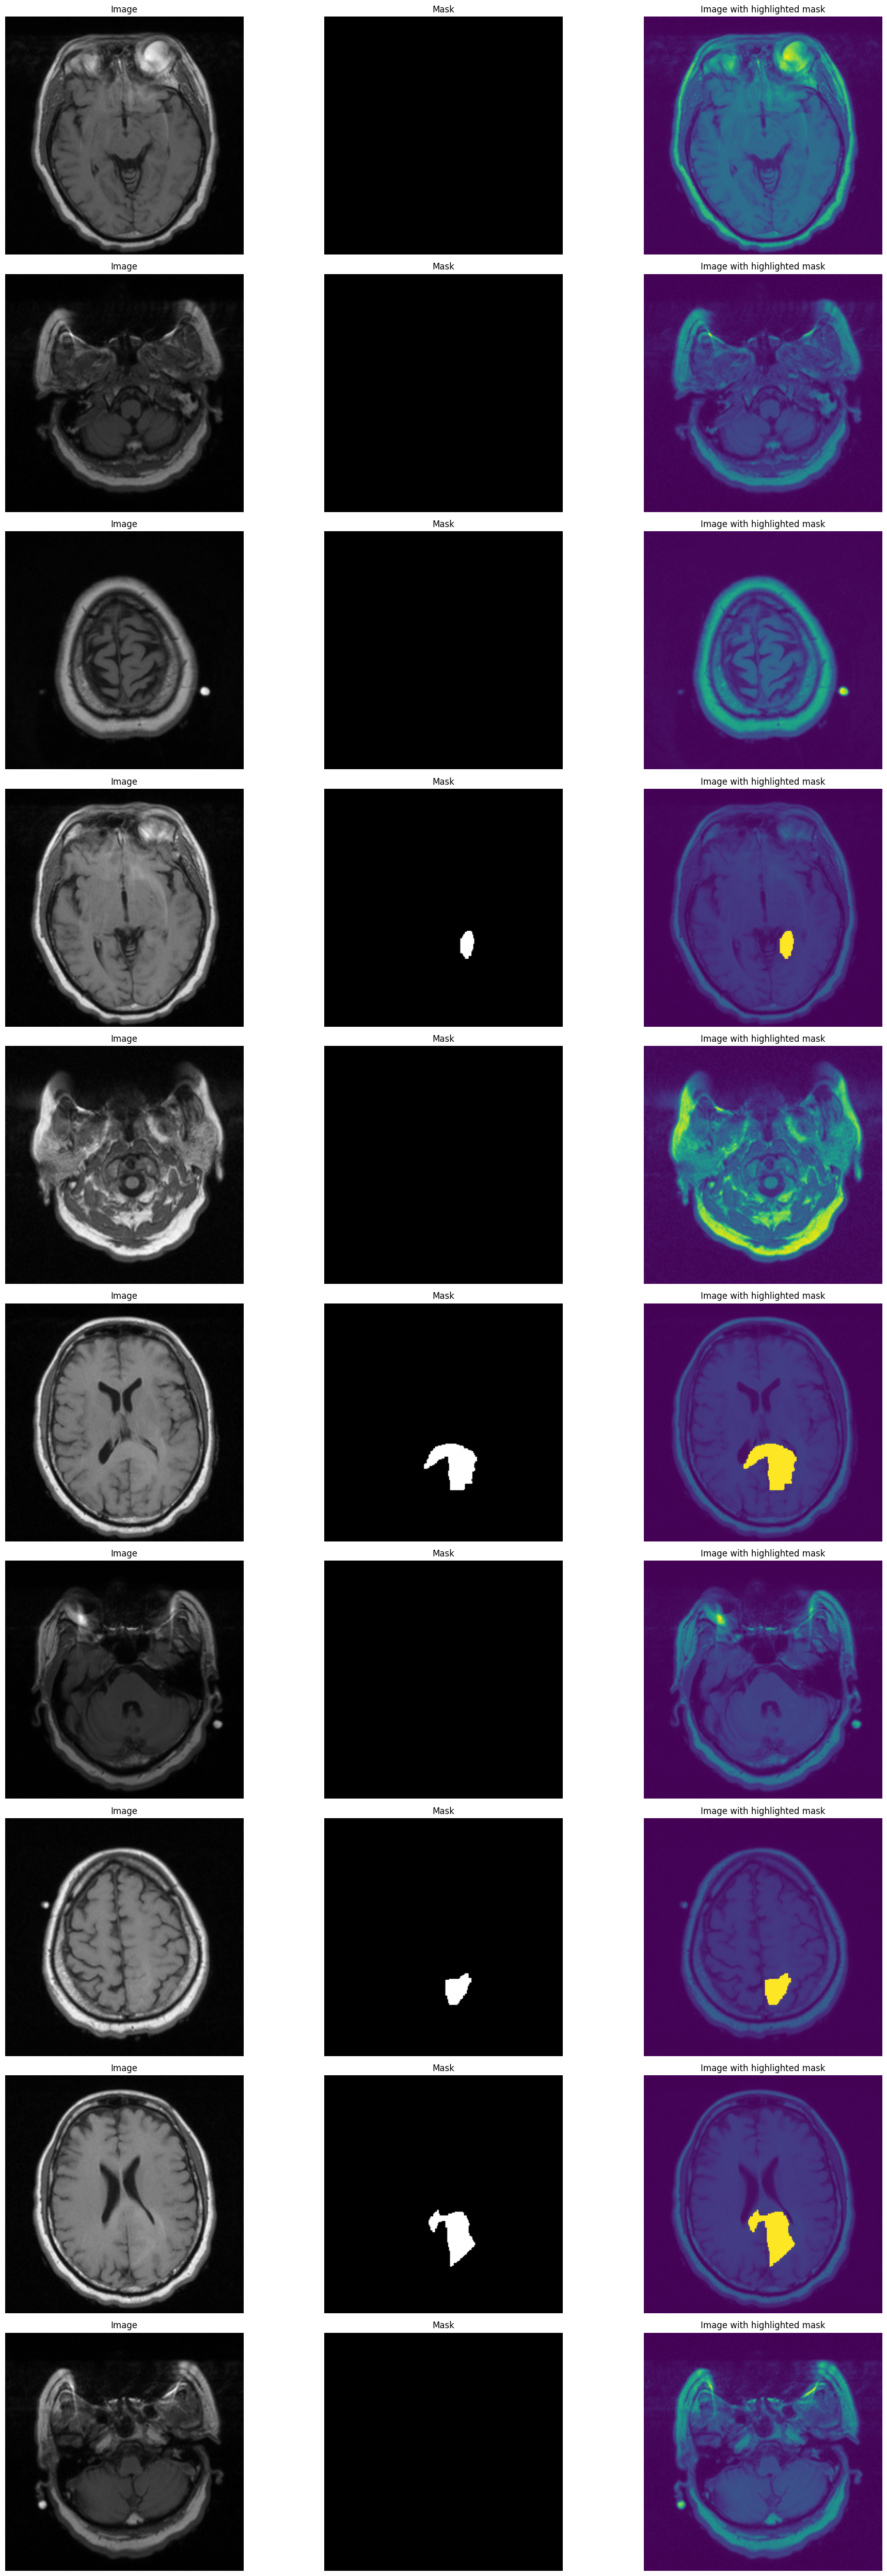

In [9]:
num_images_to_display = 10
selected_image_paths = random.sample(image_paths, num_images_to_display)
selected_mask_paths = [path.replace('.tif', '_mask.tif') for path in selected_image_paths]

plt.figure(figsize=(20, 5 * num_images_to_display))

for i, (img_path, mask_path) in enumerate(zip(selected_image_paths, selected_mask_paths)):
    # Read the image and mask
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)

    # Plot image
    plt.subplot(num_images_to_display, 3, 3 * i + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Image')
    plt.axis('off')
    print(img.shape)

    # Plot mask
    plt.subplot(num_images_to_display, 3, 3 * i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    print(mask.shape)

    # Plot image with highlighted mask
    img_copy = img.copy()
    contours, hier = cv2.findContours(mask[:, :, 0], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask_over_image = cv2.drawContours(img_copy, contours, -1, [255, 0, 0], thickness=-1)
    plt.subplot(num_images_to_display, 3, 3 * i + 3)
    plt.imshow(mask_over_image)
    plt.title('Image with highlighted mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
def display_statistics(image_path, mask_path):
    image = plt.imread(image_path)
    mask = plt.imread(mask_path)

    print("Image Statistics:")
    print(f"Shape: {image.shape}")
    print(f"Min value: {image.min()}")
    print(f"Max value: {image.max()}")

    print("\nMask Statistics:")
    print(f"Shape: {image.shape}")
    print(f"Min value: {image.min()}")
    print(f"Max value: {image.max()}")
    print(f"Unique values: {np.unique(mask)}")

display_statistics(image_paths[0], mask_paths[0])

Image Statistics:
Shape: (256, 256, 3)
Min value: 0
Max value: 201

Mask Statistics:
Shape: (256, 256, 3)
Min value: 0
Max value: 201
Unique values: [0]


# 2. Preprocessing
**Implement Image Preprocessing Techniques**

I define a function to load and preprocess images and their corresponding masks from the dataset.because of RAMlimitation, i use 3 patients


Read the image in RGB, resize to 128x128, normalize.


Read the mask in grayscale, resize to 128x128, normalize


Note: I use tqdm library to display progress bars for loops to track progress. In the code, it wraps the for loop over patient_ids to show how many patient folders have been processed.


In [12]:




def convert_tiff_to_png(tiff_path, output_path):
    """Convert TIFF file to PNG format."""
    tiff_image = Image.open(tiff_path)
    tiff_image.save(output_path, "PNG")
    print(f"Converted {tiff_path} to {output_path}")

def load_and_preprocess_data(data_path):


    img_png = []
    seg_png = []
    folder_ids = os.listdir(data_path)[:3]
    for folder_id in tqdm(folder_ids, desc='Preprocessing Images and Masks'):
        folder_path = os.path.join(data_path, folder_id)
        image_paths, _ = get_image_mask_paths(folder_path)
        for img_path in image_paths:
            mask_path = img_path.replace('.tif', '_mask.tif')
            new_img_path = img_path.replace('.tif', '.png')
            new_mask_path = mask_path.replace('.tif', '.png')

            convert_tiff_to_png(img_path, new_img_path)
            convert_tiff_to_png(mask_path, new_mask_path)

            img_png.append(new_img_path)
            seg_png.append(new_mask_path)





    return img_png , seg_png


In [36]:




class CustomImageDataset(Dataset):
    def __init__(self, image_path, mask_path, image_transform=None, mask_transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        img_path = self.image_path[idx]
        mask_path = self.mask_path[idx]
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


img_png,seg_png=load_and_preprocess_data('/content/kaggle_3m')

custom_dataset = CustomImageDataset(img_png,seg_png, image_transform=image_transform ,mask_transform=mask_transform )



Preprocessing Images and Masks:   0%|          | 0/3 [00:00<?, ?it/s]

Converted /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_6.tif to /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_6.png
Converted /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_6_mask.tif to /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_6_mask.png
Converted /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_32.tif to /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_32.png
Converted /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_32_mask.tif to /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_32_mask.png
Converted /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_45.tif to /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_45.png
Converted /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_45_mask.tif to /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_45_mask.png
Converted /content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_

# Split the Dataset into Train and Test Sets

In [37]:
from torch.utils.data import


train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size


train_ds, test_ds = random_split(custom_dataset, [train_size, test_size])


# Set Dataloaders

In [38]:

test_loader = DataLoader(dataset=test_ds, batch_size=16, shuffle=True)
train_loader = DataLoader(dataset=train_ds, batch_size=16, shuffle=True)

#  Visualization
**This function is to show one patient from your datasets, so that you can see if the it is okay or you need
to change/delete something.**





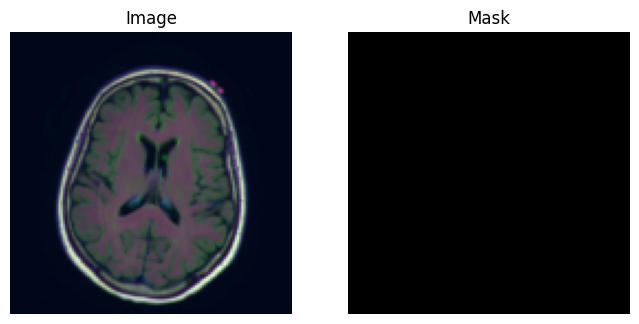

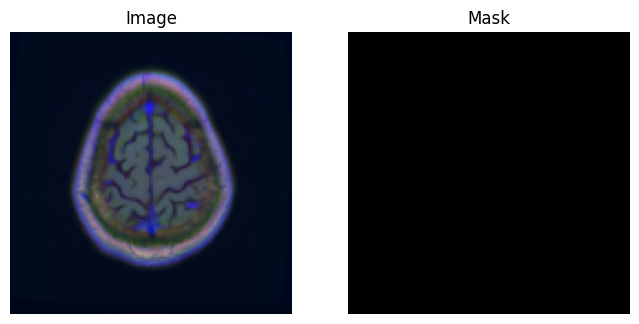

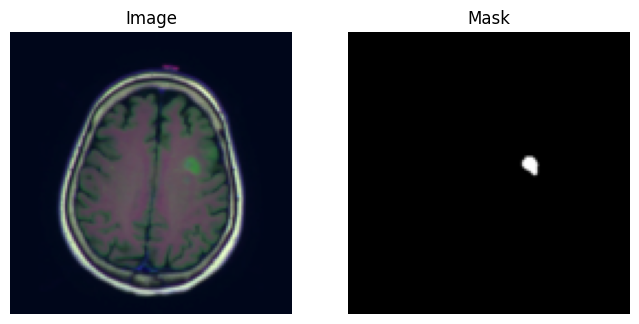

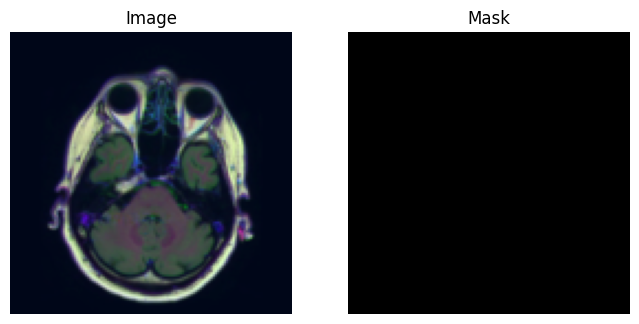

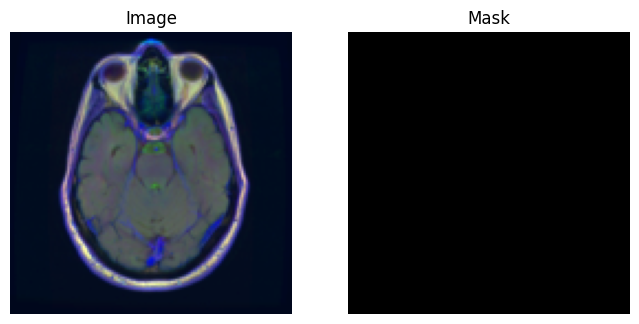

In [39]:


num_samples_to_display = 5
samples_displayed = 0

for images, masks in train_loader:
    for i in range(images.shape[0]):
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        mask = masks[i].cpu().numpy().squeeze()
        img = (img - img.min()) / (img.max() - img.min())

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.show()

        samples_displayed += 1
        if samples_displayed >= num_samples_to_display:
            break

    if samples_displayed >= num_samples_to_display:
        break


# Define our Model

In [53]:

model = smp.Unet(
    encoder_name="resnet34",
    in_channels=3,
    classes=1,
    activation='sigmoid'
)




In [42]:

optimizer = optim.Adam(model.parameters(), lr=0.001)



In [44]:

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice


dice_metric = Dice()

In [45]:
!mkdir '/content/model'

In [46]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    dice_metric = Dice().to(device)

    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        dice_metric.update(outputs, masks.int())

    train_loss /= len(train_loader.dataset)
    dice_score = dice_metric.compute().item()

    return train_loss, dice_score

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    dice_metric = Dice().to(device)

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            dice_metric.update(outputs, masks.int())

    val_loss /= len(val_loader.dataset)
    dice_score = dice_metric.compute().item()

    return val_loss, dice_score

In [55]:
def train_and_validate(train_dataset,val_dataset,
                       model, device, num_epochs, batch_size):

    train_dataset = train_dataset
    val_dataset =val_dataset
    import torch


    model_save_path = '/content/model.pth'


    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    model = model.to(device)
    criterion = DiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []

    for epoch in range(num_epochs):
        train_loss, train_dice = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_dice = validate_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        val_dices.append(val_dice)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)

    return train_losses, val_losses, train_dices, val_dices

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device...')

train_losses, val_losses, train_dices, val_dices = train_and_validate(
    train_ds,
    test_ds,
    model,
    device,
    num_epochs=5,
    batch_size=16
)

Using cpu device...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 0.9757, Val Loss: 0.9819, Train Dice: 0.0551, Val Dice: 0.0132


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/5, Train Loss: 0.9670, Val Loss: 0.9606, Train Dice: 0.1565, Val Dice: 0.0393


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/5, Train Loss: 0.9564, Val Loss: 0.9448, Train Dice: 0.2937, Val Dice: 0.0644


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/5, Train Loss: 0.9443, Val Loss: 0.9460, Train Dice: 0.2997, Val Dice: 0.0531


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/5, Train Loss: 0.9265, Val Loss: 0.8945, Train Dice: 0.4439, Val Dice: 0.2106


In [59]:
def plot_progress(train_losses, val_losses, train_dices, val_dices):
    num_epochs = len(train_losses)
    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_dices, label='Train Dice')
    plt.plot(range(1, num_epochs+1), val_dices, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Training and Validation Dice Scores')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/model')
    plt.show()

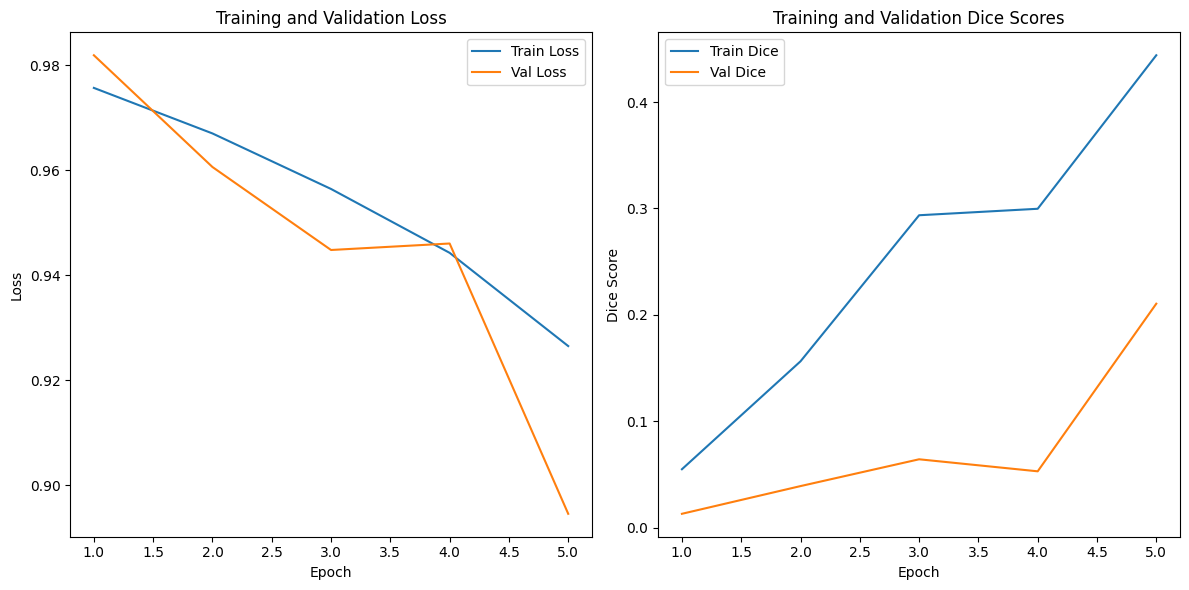

In [60]:
plot_progress(train_losses, val_losses, train_dices, val_dices)

In [62]:
best_model = smp.Unet(
    encoder_name="resnet34",
    in_channels=3,
    classes=1,
    activation='sigmoid'
)
state_dict = torch.load('/content/model.pth')
best_model.load_state_dict(state_dict)
best_model = best_model.to(device)
criterion = DiceLoss()


test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loss, test_dice = validate_one_epoch(
    best_model, test_loader, criterion, device
)

print(f'Test loss: {test_loss:.4f}')
print(f'Test dice: {test_dice:.4f}')


<ipython-input-62-412bb4c027f0>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/model.pth')
/usr/local/lib/python3.11/dist-packages/torch/

Test loss: 0.8954
Test dice: 0.2106


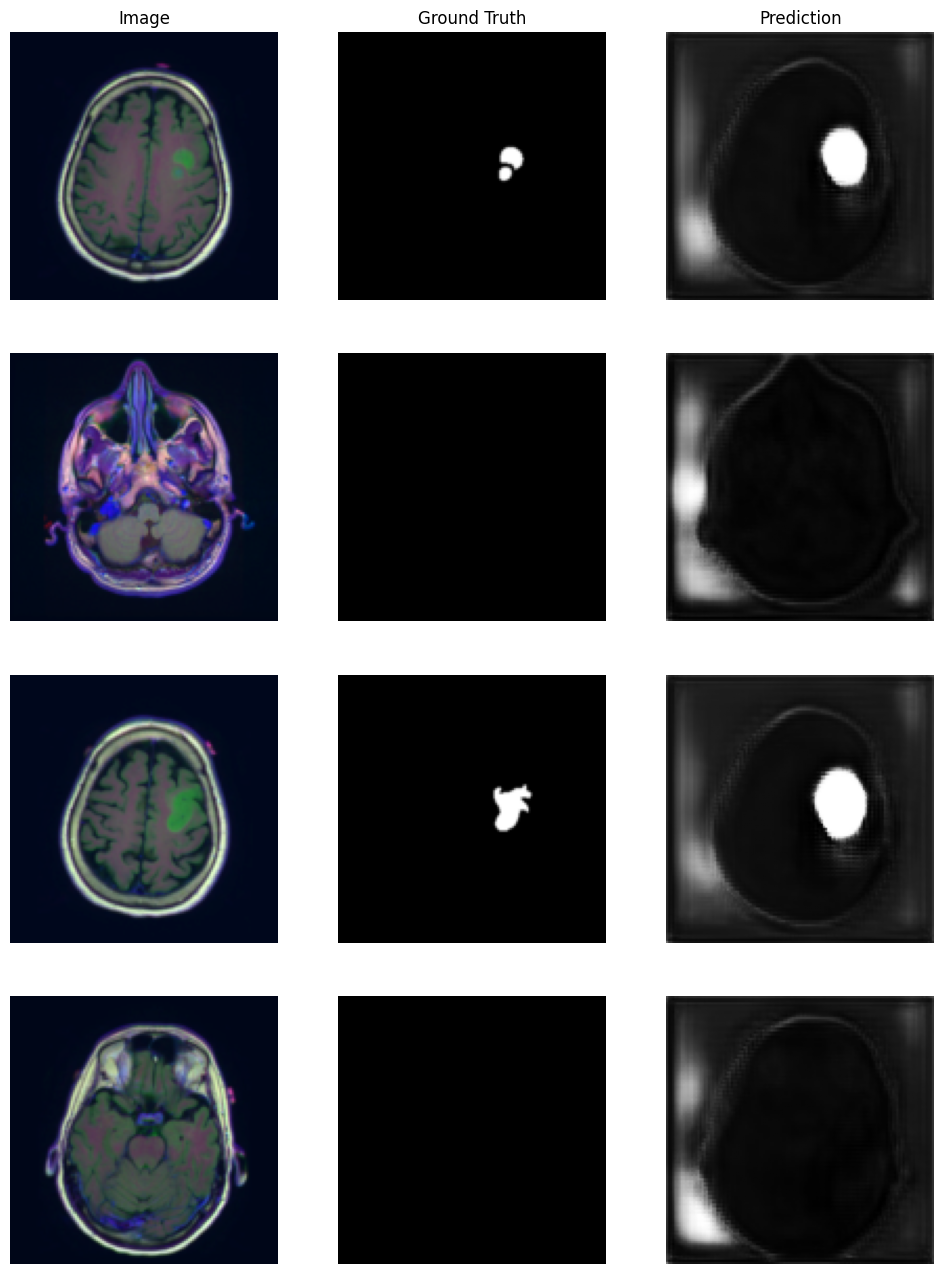

In [65]:

num_samples_to_display = 5
samples_displayed = 0


for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    outputs = best_model(images)

    fig, axs = plt.subplots(4, 3, figsize=(12, 16))
    axs[0, 0].set_title('Image')
    axs[0, 1].set_title('Ground Truth')
    axs[0, 2].set_title('Prediction')

    for i in range(4):
        if samples_displayed >= num_samples_to_display:
            break

        img = images[i].cpu().numpy().transpose(1, 2, 0)
        mask = masks[i].cpu().numpy().squeeze()
        img = (img - img.min()) / (img.max() - img.min())
        pred = outputs[i].cpu().detach().numpy().squeeze()

        axs[i, 0].imshow(img)
        axs[i, 1].imshow(mask, cmap='gray')
        axs[i, 2].imshow(pred, cmap='gray')

        for j in range(3):
            axs[i, j].axis('off')

        samples_displayed += 1

    break
